In [91]:
import os
import tarfile
from zlib import crc32

# only in a Jupyter notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix
from scipy import stats
from six.moves import urllib

# SciKit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    GridSearchCV,
    StratifiedShuffleSplit,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

## Download the Data

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"


def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
# Load data to pandas
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


> Each row represents one district. There are 10 attributes (you can see the first 6 in the
screenshot): `longitude`, `latitude`, `housing_median_age`, `total_rooms`, `total_bedrooms`,
`population`, `households`, `median_income`, `median_house_value`, and `ocean_proximity`.

### The `info()` method is useful to get a quick description of the data, in particular the total number of rows, and each attribute’s type and number of non-null values

In [6]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


### You can find out what categories exist and how many districts belong to each category by using the `value_counts()` method

In [7]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


> You can either plot this one attribute at a time, or you can call the `hist()` method on the
whole dataset, and it will plot a histogram for each numerical attribute

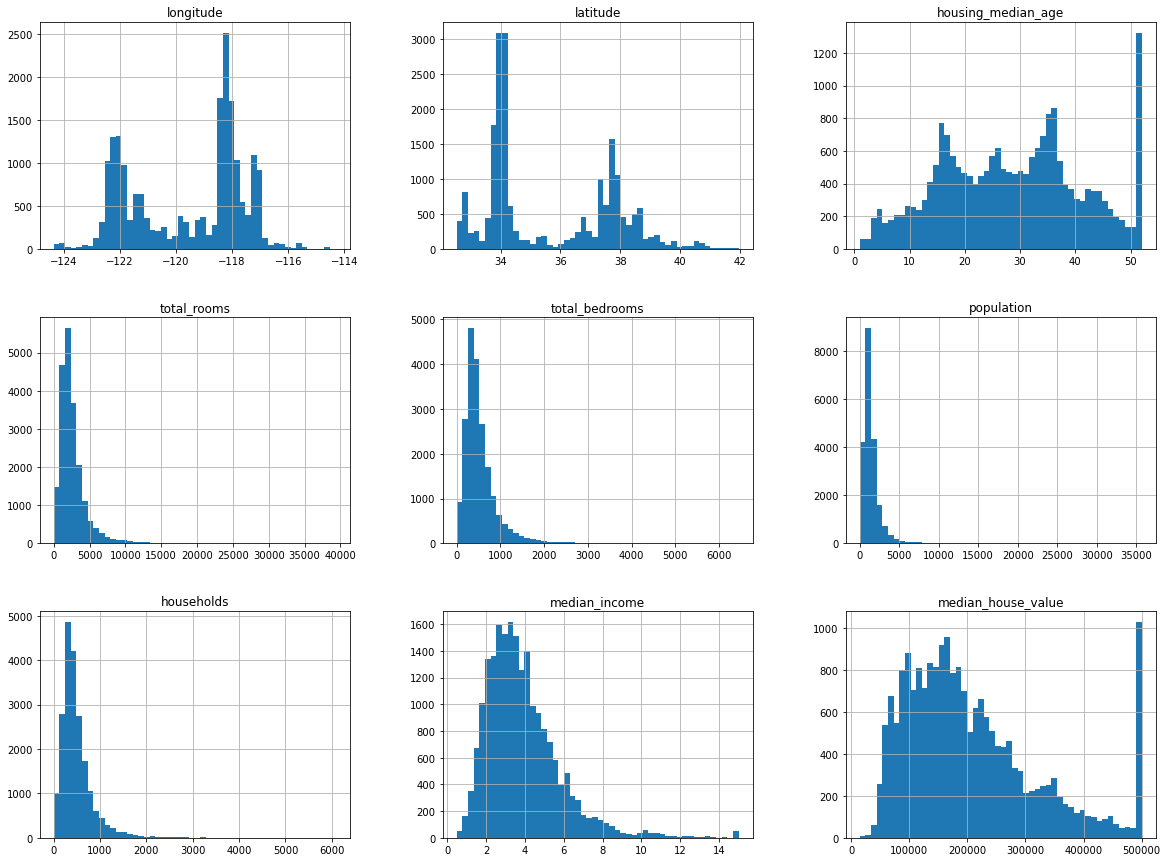

In [9]:
housing.hist(bins=50, figsize=(20, 15))
plt.show()

> A histogram for each numerical attribute

The `hist()` method relies on Matplotlib, which in turn relies on a
user-specified graphical backend to draw on your screen. So before
you can plot anything, you need to specify which backend Matplotlib should use.
The simplest option is to use Jupyter’s magic command `%matplotlib inline`.
This tells Jupyter to set up Matplotlib so it uses Jupyter’s own backend. 
Plots are then rendered within the notebook itself. Note that calling `show()`
is optional in a Jupyter notebook, as Jupyter will automatically display plots when a cell is
executed

#### Creating a test set is theoretically quite simple: just pick some instances randomly, typically 20% of the dataset

In [10]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
train_set, test_set = split_train_test(housing, 0.2)

In [12]:
len(train_set), len(test_set)

(16512, 4128)

In [13]:
shuffled_indices = np.random.permutation(15)
shuffled_indices

array([14, 12, 13,  7,  9,  4,  5,  3,  8,  6, 10,  1, 11,  2,  0])

In [14]:
test_indices = shuffled_indices[:5]
test_indices

array([14, 12, 13,  7,  9])

In [15]:
train_indices = shuffled_indices[5:]
train_indices

array([ 4,  5,  3,  8,  6, 10,  1, 11,  2,  0])

### [DataFrame.iloc.html](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.iloc.html)

In [16]:
housing.iloc[train_indices]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
5,-122.25,37.85,52.0,919.0,213.0,413.0,193.0,4.0368,269700.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY
6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY
10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY


In [17]:
housing.iloc[test_indices]

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14,-122.26,37.85,52.0,2643.0,626.0,1212.0,620.0,1.9167,159200.0,NEAR BAY
12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY
13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY
7,-122.25,37.84,52.0,3104.0,687.0,1157.0,647.0,3.1200,241400.0,NEAR BAY
9,-122.25,37.84,52.0,3549.0,707.0,1551.0,714.0,3.6912,261100.0,NEAR BAY


In [18]:
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xFFFFFFFF < test_ratio * 2 ** 32

In [19]:
test_ratio = 0.9

hashI = crc32(np.int64(1))
hashI

2844319735

In [20]:
left = hashI & 0xFFFFFFFF
left

2844319735

In [21]:
test_ratio * 2 ** 32

3865470566.4

In [22]:
left < test_ratio * 2 ** 32

True

In [23]:
def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

> Unfortunately, the housing dataset does not have an identifier column. The simplest
solution is to use the row index as the ID:

In [24]:
housing_with_id = housing.reset_index()

# adds an `index` column
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

If you use the row index as a unique identifier, you need to make sure that new data
gets appended to the end of the dataset, and no row ever gets deleted. If this is not
possible, then you can try to use the most stable features to build a unique identifier.
For example, a district’s latitude and longitude are guaranteed to be stable for a few
million years, so you could combine them into an ID like so

In [25]:
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
6,6,-122.25,37.84,52.0,2535.0,489.0,1094.0,514.0,3.6591,299200.0,NEAR BAY


In [26]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]

train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [27]:
# Look at the ID column
train_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,-122192.12
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,-122182.14
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,-122202.15
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,-122212.15
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,-122212.15


Scikit-Learn provides a few functions to split datasets into multiple subsets in various
ways. The simplest function is `train_test_split`, which does pretty much the same
thing as the function `split_train_test` defined earlier, with a couple of additional
features. First there is a `random_state` parameter that allows you to set the random
generator seed as explained previously, and second you can pass it multiple datasets
with an identical number of rows, and it will split them on the same indices (this is
very useful, for example, if you have a separate `DataFrame` for labels):

In [28]:
# Ready-to-use function to split dataset
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

train_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
14196,-117.03,32.71,33.0,3126.0,627.0,2300.0,623.0,3.2596,103000.0,NEAR OCEAN
8267,-118.16,33.77,49.0,3382.0,787.0,1314.0,756.0,3.8125,382100.0,NEAR OCEAN
17445,-120.48,34.66,4.0,1897.0,331.0,915.0,336.0,4.1563,172600.0,NEAR OCEAN
14265,-117.11,32.69,36.0,1421.0,367.0,1418.0,355.0,1.9425,93400.0,NEAR OCEAN
2271,-119.80,36.78,43.0,2382.0,431.0,874.0,380.0,3.5542,96500.0,INLAND


In [29]:
housing["income_cat"] = pd.cut(
    housing["median_income"],
    bins=[0.0, 1.5, 3.0, 4.5, 6.0, np.inf],
    labels=[1, 2, 3, 4, 5],
)
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


<AxesSubplot:>

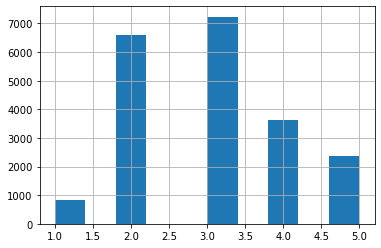

In [30]:
housing["income_cat"].hist()

Now you are ready to do stratified sampling based on the income category. For this
you can use Scikit-Learn’s `StratifiedShuffleSplit` class:

In [31]:
s = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in s.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [32]:
strat_test_set["income_cat"].value_counts()

3    1447
2    1316
4     728
5     473
1     164
Name: income_cat, dtype: int64

With similar code you can measure the income category proportions in the full dataset.
Compares the income category proportions in the overall dataset, in
the test set generated with stratified sampling, and in a test set generated using purely
random sampling. As you can see, the test set generated using stratified sampling has
income category proportions almost identical to those in the full dataset, whereas the
test set generated using purely random sampling is quite skewed.

In [33]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

## Discover and Visualize the Data to Gain Insights

In [34]:
housing = strat_train_set.copy()

### Visualizing Geographical Data

Since there is geographical information (latitude and longitude), it is a good idea to
create a scatterplot of all districts to visualize the data

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

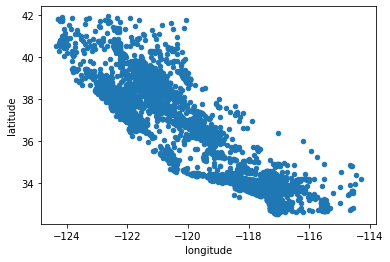

In [35]:
housing.plot(kind="scatter", x="longitude", y="latitude")

This looks like California all right, but other than that it is hard to see any particular
pattern. Setting the alpha option to 0.1 makes it much easier to visualize the places
where there is a high density of data points

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

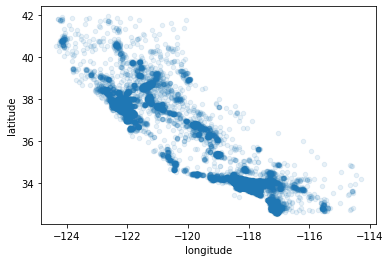

In [36]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

> A better visualization highlighting high-density areas

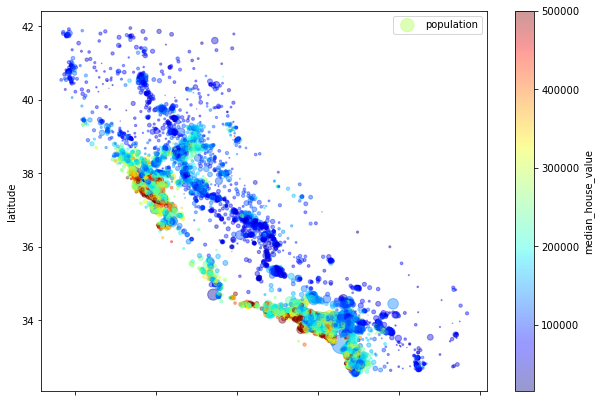

In [37]:
housing.plot(
    kind="scatter",
    x="longitude",
    y="latitude",
    alpha=0.4,
    s=housing["population"] / 100,
    label="population",
    figsize=(10, 7),
    c="median_house_value",
    cmap=plt.get_cmap("jet"),
    colorbar=True,
)
plt.legend()

> California housing prices

### Looking for Correlations

In [38]:
corr_matrix = housing.corr()

corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

In [39]:
# Full corr matrix view

corr_matrix

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
longitude,1.000000,-0.924478,-0.105848,0.048871,0.076598,0.108030,0.063070,-0.019583,-0.047432
latitude,-0.924478,1.000000,0.005766,-0.039184,-0.072419,-0.115222,-0.077647,-0.075205,-0.142724
housing_median_age,-0.105848,0.005766,1.000000,-0.364509,-0.325047,-0.298710,-0.306428,-0.111360,0.114110
total_rooms,0.048871,-0.039184,-0.364509,1.000000,0.929379,0.855109,0.918392,0.200087,0.135097
total_bedrooms,0.076598,-0.072419,-0.325047,0.929379,1.000000,0.876320,0.980170,-0.009740,0.047689
population,0.108030,-0.115222,-0.298710,0.855109,0.876320,1.000000,0.904637,0.002380,-0.026920
households,0.063070,-0.077647,-0.306428,0.918392,0.980170,0.904637,1.000000,0.010781,0.064506
median_income,-0.019583,-0.075205,-0.111360,0.200087,-0.009740,0.002380,0.010781,1.000000,0.687160
median_house_value,-0.047432,-0.142724,0.114110,0.135097,0.047689,-0.026920,0.064506,0.687160,1.000000


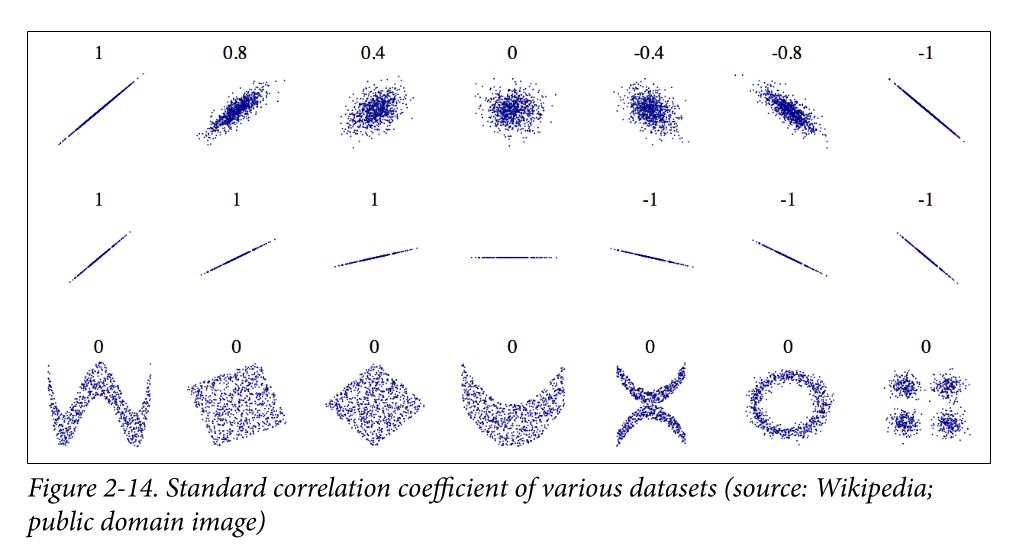

> Another way to check for correlation between attributes is to use Pandas’
`scatter_matrix` function, which plots every numerical attribute against every other
numerical attribute. Since there are now 11 numerical attributes, you would get 112 =
121 plots, which would not fit on a page, so let’s just focus on a few promising
attributes that seem most correlated with the median housing value

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

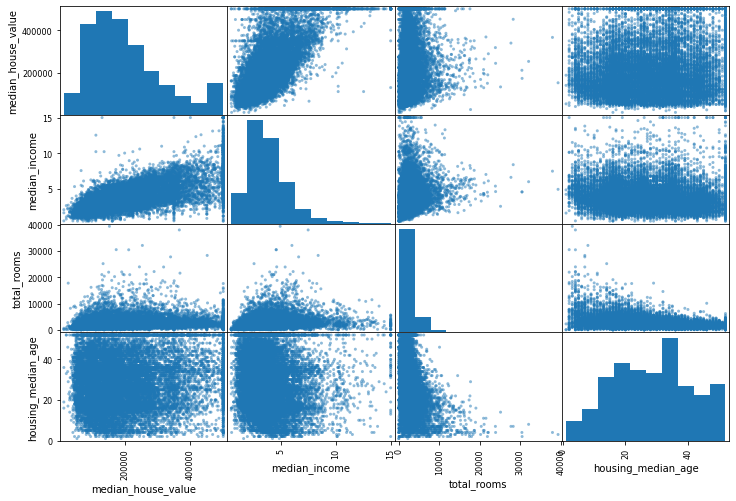

In [40]:
attributes = [
    "median_house_value",
    "median_income",
    "total_rooms",
    "housing_median_age",
]

scatter_matrix(housing[attributes], figsize=(12, 8))

The most promising attribute to predict the median house value is the median
income, so let’s zoom in on their correlation `scatterplot`

<AxesSubplot:xlabel='median_income', ylabel='median_house_value'>

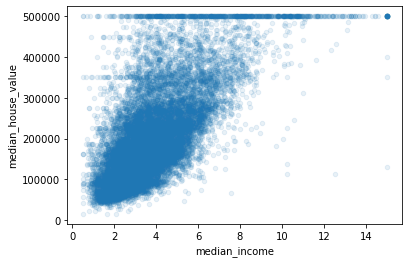

In [41]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1)

<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>

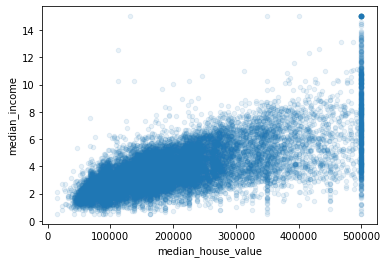

In [42]:
housing.plot(kind="scatter", x="median_house_value", y="median_income", alpha=0.1)

> This plot reveals a few things. First, the correlation is indeed very strong; you can
clearly see the upward trend and the points are not too dispersed. Second, the price
cap that we noticed earlier is clearly visible as a horizontal line at \\$500,000. But this
plot reveals other less obvious straight lines: a horizontal line around \\$450,000,
another around \\$350,000, perhaps one around \\$280,000, and a few more below that.
You may want to try removing the corresponding districts to prevent your algorithms
from learning to reproduce these data quirks.

## Experimenting with Attribute Combinations

Hopefully the previous sections gave you an idea of a few ways you can explore the
data and gain insights. You identified a few data quirks that you may want to clean up
before feeding the data to a Machine Learning algorithm, and you found interesting
correlations between attributes, in particular with the target attribute. You also
noticed that some attributes have a tail-heavy distribution, so you may want to trans‐
form them (e.g., by computing their logarithm). Of course, your mileage will vary
considerably with each project, but the general ideas are similar.
One last thing you may want to do before actually preparing the data for Machine
Learning algorithms is to try out various attribute combinations. For example, the
total number of rooms in a district is not very useful if you don’t know how many
households there are. What you really want is the number of rooms per household.
Similarly, the total number of bedrooms by itself is not very useful: you probably
want to compare it to the number of rooms. And the population per household also
seems like an interesting attribute combination to look at. Let’s create these new
attributes:

In [43]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

> And now let’s look at the correlation matrix again

In [44]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

## Prepare the Data for Machine Learning Algorithms

But first let’s revert to a clean training set (by copying `strat_train_set` once again),
and let’s separate the predictors and the labels since we don’t necessarily want to apply
the same transformations to the predictors and the target values (note that `drop()`
creates a copy of the data and does not affect `strat_train_set`):

In [45]:
housing = strat_train_set.drop("median_house_value", axis=1)

housing_labels = strat_train_set["median_house_value"].copy()

### Data Cleaning

You noticed earlier that the total_bedrooms
attribute has some missing values, so let’s fix this

In [46]:
# Get rid of the corresponding districts - drop missing values
housing.dropna(subset=["total_bedrooms"])

# Get rid of the whole attribute
housing.drop("total_bedrooms", axis=1)

# Set the values to some value (zero, the mean, the median, etc.)
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median, inplace=True)

Scikit-Learn provides a handy class to take care of missing values: `SimpleImputer`.
Here is how to use it. First, you need to create a `SimpleImputer` instance, specifying
that you want to replace each attribute’s missing values with the median of that
attribute

In [47]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042,<1H OCEAN
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214,<1H OCEAN
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621,NEAR OCEAN
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839,INLAND
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347,<1H OCEAN


In [48]:
imputer = SimpleImputer(strategy="median")

Since the median can only be computed on numerical attributes, we need to create a
copy of the data without the text attribute `ocean_proximity`

In [49]:
housing_num = housing.drop("ocean_proximity", axis=1)
housing_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
17606,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
18632,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
14650,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3230,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
3555,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


Now you can fit the imputer instance to the training data using the `fit()` method:

In [50]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

The `imputer` has simply computed the median of each attribute and stored the result
in its `statistics_` instance variable. Only the `total_bedrooms` attribute had missing
values, but we cannot be sure that there won’t be any missing values in new data after
the system goes live, so it is safer to apply the `imputer` to all the numerical attributes

In [51]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

## Strategy of the estimator

In [52]:
imputer.strategy

'median'

In [53]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

Now you can use this “trained” imputer to transform the training set by replacing
missing values by the learned medians

In [54]:
X = imputer.transform(housing_num)
X[:5]

array([[-1.2189e+02,  3.7290e+01,  3.8000e+01,  1.5680e+03,  3.5100e+02,
         7.1000e+02,  3.3900e+02,  2.7042e+00],
       [-1.2193e+02,  3.7050e+01,  1.4000e+01,  6.7900e+02,  1.0800e+02,
         3.0600e+02,  1.1300e+02,  6.4214e+00],
       [-1.1720e+02,  3.2770e+01,  3.1000e+01,  1.9520e+03,  4.7100e+02,
         9.3600e+02,  4.6200e+02,  2.8621e+00],
       [-1.1961e+02,  3.6310e+01,  2.5000e+01,  1.8470e+03,  3.7100e+02,
         1.4600e+03,  3.5300e+02,  1.8839e+00],
       [-1.1859e+02,  3.4230e+01,  1.7000e+01,  6.5920e+03,  1.5250e+03,
         4.4590e+03,  1.4630e+03,  3.0347e+00]])

The result is a plain NumPy array containing the transformed features. If you want to
put it back into a Pandas `DataFrame`, it’s simple:

In [55]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)

housing_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-121.89,37.29,38.0,1568.0,351.0,710.0,339.0,2.7042
1,-121.93,37.05,14.0,679.0,108.0,306.0,113.0,6.4214
2,-117.20,32.77,31.0,1952.0,471.0,936.0,462.0,2.8621
3,-119.61,36.31,25.0,1847.0,371.0,1460.0,353.0,1.8839
4,-118.59,34.23,17.0,6592.0,1525.0,4459.0,1463.0,3.0347


### Handling Text and Categorical Attributes

In [56]:
housing_cat = housing[["ocean_proximity"]]

housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


Most Machine Learning algorithms prefer to work with numbers anyway, so let’s convert these categories from text to numbers. For this, we can use Scikit-Learn’s `OrdinalEncoder` class

In [57]:
ordinal_encoder = OrdinalEncoder()

# Encode data instead of text = id
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

You can get the list of categories using the `categories_` instance variable. It is a list
containing a 1D array of categories for each categorical attribute (in this case, a list
containing a single array since there is just one categorical attribute):

In [58]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [59]:
cat_encoder = OneHotEncoder()

housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [60]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

Once again, you can get the list of categories using the encoder’s `categories_`
instance variable:

In [61]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## Custom Transformers

Although Scikit-Learn provides many useful transformers, you will need to write your own for tasks such as custom cleanup operations or combining specific
attributes. You will want your transformer to work seamlessly with Scikit-Learn functionalities (such as pipelines), and since Scikit-Learn relies on duck typing (not inheritance), all you need is to create a class and implement three methods: `fit()` (returning self), `transform()`, and `fit_transform()`. You can get the last one for free by simply adding `TransformerMixin` as a base class. Also, if you add `BaseEstimator` as a base class (and avoid *args and **kargs in your constructor) you will get two extra methods (`get_params()` and `set_params()`) that will be useful for automatic hyperparameter tuning. For example, here is a small transformer class that adds the combined attributes we discussed earlier:

In [62]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6


class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]

        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[
                X, rooms_per_household, population_per_household, bedrooms_per_room
            ]
        else:
            return np.c_[X, rooms_per_household, population_per_household]


attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)

housing_extra_attribs = attr_adder.transform(housing.values)

housing_extra_attribs_df = pd.DataFrame(
    housing_extra_attribs,
    columns=[*housing.columns, "rooms_per_household", "population_per_household"],
)

housing_extra_attribs_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-121.89,37.29,38,1568,351,710,339,2.7042,<1H OCEAN,4.62537,2.0944
1,-121.93,37.05,14,679,108,306,113,6.4214,<1H OCEAN,6.00885,2.70796
2,-117.2,32.77,31,1952,471,936,462,2.8621,NEAR OCEAN,4.22511,2.02597
3,-119.61,36.31,25,1847,371,1460,353,1.8839,INLAND,5.23229,4.13598
4,-118.59,34.23,17,6592,1525,4459,1463,3.0347,<1H OCEAN,4.50581,3.04785


> In this example the transformer has one hyperparameter, `add_bedrooms_per_room`, set to `True` by default (it is often helpful to provide sensible defaults). This hyperparameter will allow you to easily find out whether adding this attribute helps the Machine Learning algorithms or not. More generally, you can add a hyperparameter to gate any data preparation step that you are not 100% sure about. The more you automate these data preparation steps, the more combinations you can automatically try out, making it much more likely that you will find a great combination (and saving you a lot of time)

## Transformation Pipelines

In [63]:
num_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("attribs_adder", CombinedAttributesAdder()),
        ("std_scaler", StandardScaler()),
    ]
)

housing_num_tr = num_pipeline.fit_transform(housing_num)

housing_num_tr = pd.DataFrame(
    housing_num_tr,
    columns=[
        *housing_num.columns,
        "rooms_per_household",
        "population_per_household",
        "bedrooms_per_room",
    ],
)

housing_num_tr.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room
0,-1.156043,0.771950,0.743331,-0.493234,-0.445438,-0.636211,-0.420698,-0.614937,-0.312055,-0.086499,0.155318
1,-1.176025,0.659695,-1.165317,-0.908967,-1.036928,-0.998331,-1.022227,1.336459,0.217683,-0.033534,-0.836289
2,1.186849,-1.342183,0.186642,-0.313660,-0.153345,-0.433639,-0.093318,-0.532046,-0.465315,-0.092405,0.422200
3,-0.017068,0.313576,-0.290520,-0.362762,-0.396756,0.036041,-0.383436,-1.045566,-0.079661,0.089736,-0.196453
4,0.492474,-0.659299,-0.926736,1.856193,2.412211,2.724154,2.570975,-0.441437,-0.357834,-0.004194,0.269928


In [64]:
num_attribs = list(housing_num)

cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer(
    [
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ]
)

housing_prepared = full_pipeline.fit_transform(housing)

housing_prepared[1]

array([-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
       -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
       -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
        0.        ])

> Instead of a transformer, you can specify the string "drop" if you
want the columns to be dropped. Or you can specify "pass
through" if you want the columns to be left untouched. By default,
the remaining columns (i.e., the ones that were not listed) will be
dropped, but you can set the remainder hyperparameter to any
transformer (or to "passthrough") if you want these columns to be
handled differently.

## Select and Train a Model

The good news is that thanks to all these previous steps, things are now going to be
much simpler than you might think. Let’s first train a Linear Regression model, like
we did in the previous chapter:

In [65]:
housing_labels[:5]

17606    286600.0
18632    340600.0
14650    196900.0
3230      46300.0
3555     254500.0
Name: median_house_value, dtype: float64

In [66]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [67]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

print("Labels:", list(some_labels))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]
Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


> It works, although the predictions are not exactly accurate (e.g., the first prediction is off by close to 40%!). Let’s measure this regression model’s RMSE on the whole training set using Scikit-Learn’s `mean_squared_error` function:

In [68]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)

lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

Let’s train a `DecisionTreeRegressor`. This is a powerful model, capable of finding
complex nonlinear relationships in the data (Decision Trees are presented in more
detail in Chapter 6). The code should look familiar by now:

In [69]:
tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [70]:
housing_predictions = tree_reg.predict(housing_prepared)

tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

tree_rmse

0.0

## Better Evaluation Using Cross-Validation

A great alternative is to use Scikit-Learn’s K-fold cross-validation feature. The following code randomly splits the training set into 10 distinct subsets called folds, then it trains and evaluates the Decision Tree model 10 times, picking a different fold for evaluation every time and training on the other 9 folds. The result is an array containing the 10 evaluation scores

In [71]:
scores = cross_val_score(
    tree_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10
)

tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores

array([69401.10291367, 66337.34511256, 70806.90556372, 68265.22763884,
       70946.42529449, 75412.89592075, 71577.41743832, 72805.36562897,
       74380.45448729, 70406.40314316])

In [72]:
def display_scores(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation:", scores.std())


display_scores(tree_rmse_scores)

Scores:  [69401.10291367 66337.34511256 70806.90556372 68265.22763884
 70946.42529449 75412.89592075 71577.41743832 72805.36562897
 74380.45448729 70406.40314316]
Mean:  71033.9543141757
Standard deviation: 2581.679012661081


Now the Decision Tree doesn’t look as good as it did earlier. In fact, it seems to perform worse than the Linear Regression model! Notice that cross-validation allows you to get not only an estimate of the performance of your model, but also a measure of how precise this estimate is (i.e., its standard deviation). The Decision Tree has a score of approximately 71,407, generally ±2,439. You would not have this information if you just used one validation set. But cross-validation comes at the cost of training the model several times, so it is not always possible. Let’s compute the same scores for the Linear Regression model just to be sure:

In [73]:
lin_scores = cross_val_score(
    lin_reg, housing_prepared, housing_labels, scoring="neg_mean_squared_error", cv=10
)

lin_rmse_scores = np.sqrt(-lin_scores)

display_scores(lin_rmse_scores)

Scores:  [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean:  69052.46136345083
Standard deviation: 2731.674001798348


> That’s right: the Decision Tree model is overfitting so badly that it performs worse than the Linear Regression model.

In [74]:
forest_reg = RandomForestRegressor()

forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor()

In [75]:
housing_predictions = forest_reg.predict(housing_prepared)

housing_predictions

array([260125.  , 330546.02, 223606.  , ..., 105555.  , 207801.  ,
       455850.68])

In [76]:
forest_reg_score = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_reg_score)

forest_rmse

18697.285574047866

In [77]:
forest_reg_score = cross_val_score(
    forest_reg,
    housing_prepared,
    housing_labels,
    scoring="neg_mean_squared_error",
    cv=10,
)

forest_reg_rmse = np.sqrt(-forest_reg_score)

display_scores(forest_reg_rmse)

Scores:  [49329.34043117 47631.38433415 49816.62825536 52221.43042803
 49848.88869464 53102.115413   48695.81935558 48048.27431606
 52776.26433598 50238.56933221]
Mean:  50170.871489618825
Standard deviation: 1834.5889475242727


# Fine-Tune Your Model

## Grid Search

One way to do that would be to fiddle with the hyperparameters manually, until you
find a great combination of hyperparameter values. This would be very tedious work,
and you may not have time to explore many combinations.

Instead you should get Scikit-Learn’s `GridSearchCV` to search for you. All you need to
do is tell it which hyperparameters you want it to experiment with, and what values to
try out, and it will evaluate all the possible combinations of hyperparameter values,
using cross-validation. For example, the following code searches for the best combination
of hyperparameter values for the `RandomForestRegressor`:

In [78]:
param_grid = [
    {"n_estimators": [3, 10, 30], "max_features": [2, 4, 6, 8]},
    {"bootstrap": [False], "n_estimators": [3, 10], "max_features": [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(
    forest_reg,
    param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    return_train_score=True,
)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [79]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [80]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

### And of course the evaluation scores are also available:

In [81]:
cvres = grid_search.cv_results_

for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64454.51084062917 {'max_features': 2, 'n_estimators': 3}
55583.319640450856 {'max_features': 2, 'n_estimators': 10}
52905.17716219099 {'max_features': 2, 'n_estimators': 30}
59503.89125564645 {'max_features': 4, 'n_estimators': 3}
52977.485416018695 {'max_features': 4, 'n_estimators': 10}
50553.45776585885 {'max_features': 4, 'n_estimators': 30}
59089.1970222503 {'max_features': 6, 'n_estimators': 3}
52184.08011793557 {'max_features': 6, 'n_estimators': 10}
49822.26070346932 {'max_features': 6, 'n_estimators': 30}
58934.06061581591 {'max_features': 8, 'n_estimators': 3}
52009.899891299196 {'max_features': 8, 'n_estimators': 10}
50148.75296222082 {'max_features': 8, 'n_estimators': 30}
62489.09111653191 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54858.58429584018 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60691.361238059166 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52575.83211621317 {'bootstrap': False, 'max_features': 3, 'n_estimators':

> In this example, we obtain the best solution by setting the max_features hyperparameter to 8, and the n_estimators hyperparameter to 30. The RMSE score for this combination is 49,682, which is slightly better than the score you got earlier using the default hyperparameter values (which was 50,182). Congratulations, you have successfully fine-tuned your best model!

## Analyze the Best Models and Their Errors

In [82]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.07408509e-02, 6.96822966e-02, 4.28318889e-02, 1.70915710e-02,
       1.59681682e-02, 1.75939734e-02, 1.62727327e-02, 3.08245527e-01,
       7.59372315e-02, 1.10038707e-01, 6.98558289e-02, 1.29244746e-02,
       1.53729458e-01, 9.37334801e-05, 1.68734828e-03, 7.30620953e-03])

### Let’s display these importance scores next to their corresponding attribute names:

In [83]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

[(0.30824552748387474, 'median_income'),
 (0.15372945770738236, 'INLAND'),
 (0.11003870680006542, 'pop_per_hhold'),
 (0.08074085094695813, 'longitude'),
 (0.07593723146158406, 'rooms_per_hhold'),
 (0.06985582891155542, 'bedrooms_per_room'),
 (0.06968229656847925, 'latitude'),
 (0.042831888911995505, 'housing_median_age'),
 (0.017593973435118, 'population'),
 (0.017091570959532888, 'total_rooms'),
 (0.016272732670897978, 'households'),
 (0.01596816821406085, 'total_bedrooms'),
 (0.012924474636409397, '<1H OCEAN'),
 (0.007306209531897171, 'NEAR OCEAN'),
 (0.001687348280050466, 'NEAR BAY'),
 (9.373348013844031e-05, 'ISLAND')]

## Evaluate Your System on the Test Set

In [88]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

47733.99862200868

In [93]:
confidence = 0.95

squared_errors = (final_predictions - y_test) ** 2

np.sqrt(
    stats.t.interval(
        confidence,
        len(squared_errors) - 1,
        loc=squared_errors.mean(),
        scale=stats.sem(squared_errors),
    )
)

array([45753.38832557, 49635.63947026])